In [1]:
main_question = "Can you tell me how we can reverse words in string 'I am a boy'?"

ideal_answer = '''#### Strategy
Two Pointers.

#### Explanation
First, the algorithm splits the words of the sentence from a string into an array.\
The algorithm also initializes low and high pointers as the first and last indexes of the array.\
Then, the algorithm iterates the array.

For each iteration, the algorithm swaps the words at the low and high pointers,\
increments and decrements the low and high pointers respectively,\
and repeats until the low pointer is greater than the high pointer.

The result is all words of the sentence reversed in the array.\
The words are joined as a string again with a single space separating the words, and the string is returned.

##### Time Complexity
The algorithm updates the low and high pointers a number of times proportional to the number of words. \
Therefore, the time complexity of the algorithm is O(n), where n is the number of words.

##### Space Complexity
The algorithm splits the words from a sentence into an array. The array is auxiliary space and has length equal to the number of words.\
Therefore, the auxiliary space complexity of the algorithm is O(n).'''

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
from typing import Annotated, TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

In [4]:
llm = ChatGroq(model="llama-3.2-90b-text-preview")

In [5]:
class Candidate(BaseModel):
    name: str
    job_role: str

class Evaluation(BaseModel):
    is_correct: bool
    evaluation: Optional[str] = None

In [6]:
class State(TypedDict):
    sub_history: Optional[str] = None
    candidate_name: Optional[str] = None
    role: Optional[str] = None
    sub_question: Optional[str] = None
    answer: Optional[str] = None
    evaluation: Optional[str] = None
    is_correct: Optional[bool] = None

workflow = StateGraph(State)

In [7]:
prompt_extraction = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        ("human", "{text}"),
    ]
)

prompt_evaluation = '''You are an expert evaluator. I have series of question and answers from user and an ideal overall answer. Determine if the user's answer matches the key points in the ideal answer.

1. If the user's answer covers the essential points, return:
   - is_correct: "True"
   - evaluation: None

2. If the user's answer does not cover the essential points, return:
   - is_correct: "False"
   - evaluation: Explain briefly what is lacking in the answer.

**Here's the information for you:**

- **Chat History:** {history}
- **Ideal Answer:** {ideal_answer}'''


prompt_sub_question = '''You are an interviewer. You are taking interview of {name}
This is a interview so far:
{history}\n
And here is evaluation of recent answer from user:
{evaluation}\n
Ask a follow up based on this.'''

prompt_verdict = '''How do you feel about the overall interview given below?
{history}'''

In [8]:
def introduction(state: State):
    intro = "Hi, I am Noha, can you please introduce yourself and what you do?"
    print("Noha: ", intro)
    return {"sub_history":''}

def handle_intro(state: State):
    user_input = input("User: ")
    runnable = prompt_extraction | llm.with_structured_output(schema=Candidate)
    candidate = runnable.invoke({'text': user_input})
    return {"candidate_name":candidate.name, "role":candidate.job_role}

def ask_main_question(state: State):
    question = main_question
    print("Noha: ", question)
    return {"sub_history":"question: "+question}

def get_answer(state: State):
    sub_history = state.get('sub_history', '').strip()
    user_input = input("User: ")
    return {"sub_history":sub_history+'\n'+"user: "+user_input,"answer":user_input}

def evaluate_answer(state: State):
    sub_history = state.get('sub_history', '').strip()

    prompt = prompt_evaluation.format(history=sub_history, ideal_answer=ideal_answer)
    text = llm.invoke(prompt).content
    runnable = prompt_extraction | llm.with_structured_output(schema=Evaluation)
    eval = runnable.invoke({'text':text})
    return {"is_correct":eval.is_correct, "evaluation":eval.evaluation}

def ask_sub_question(state: State):
    sub_history = state.get('sub_history', '').strip()
    evaluation = state.get('evaluation', '').strip()
    candidate_name = state.get('candidate_name', '').strip()

    prompt = prompt_sub_question.format(name=candidate_name, history=sub_history, evaluation=evaluation)
    question = llm.invoke(prompt).content
    print("Noha: ", question)
    return {"sub_history":sub_history+'\n'+"question: "+question}

def next_question(state: State):
    print("Noha: Lets move to the next question.")
    return {"sub_history":''}

In [9]:
def check_correct_answer(state: State):
    if state.get('is_correct'):
        return "next_question"
    else:
        return "ask_sub_question"

In [10]:
workflow.add_node("introduction", introduction)
workflow.add_node("handle_intro", handle_intro)
workflow.add_node("ask_main_question", ask_main_question)
workflow.add_node("get_answer", get_answer)
workflow.add_node("evaluate_answer", evaluate_answer)
workflow.add_node("ask_sub_question", ask_sub_question)
workflow.add_node("next_question", next_question)

In [11]:
workflow.add_conditional_edges(
    "evaluate_answer",
    check_correct_answer,
    {"ask_sub_question":"ask_sub_question","next_question":"next_question"}
    )

workflow.add_edge(START, "introduction")
workflow.add_edge("introduction","handle_intro")
workflow.add_edge("handle_intro","ask_main_question")
workflow.add_edge("ask_main_question","get_answer")
workflow.add_edge("get_answer","evaluate_answer")
workflow.add_edge("ask_sub_question","get_answer")
workflow.add_edge("next_question",END)

In [12]:
app = workflow.compile()

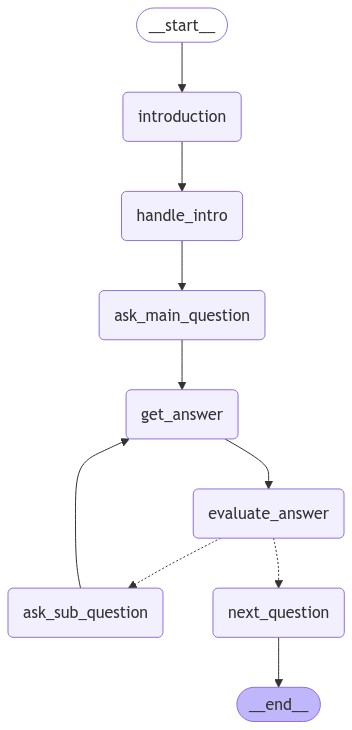

In [13]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
for event in app.stream({"sub_history":'',"candidate_name":'',"role":'',"total_questions":0,"question":'',"answer":''}):
    print(event)

Noha:  Hi, I am Noha, can you please introduce yourself and what you do?
{'introduction': {'sub_history': ''}}
{'handle_intro': {'candidate_name': 'Aniket', 'role': 'Data Scientist'}}
Noha:  Can you tell me how we can reverse words in string 'I am a boy'?
{'ask_main_question': {'sub_history': "question: Can you tell me how we can reverse words in string 'I am a boy'?"}}
